<a href="https://colab.research.google.com/github/IvanDaniarAP/MLTask/blob/main/week-7/XGBOOST_melbourne_house_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install pdpbox


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 16.5 MB/s eta 0:00:00


In [44]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# from IPython.display import display
import geopandas
import json
from datetime import date
import holidays
import matplotlib.ticker as ticker
from IPython.core.display import HTML
import plotly.offline as offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import widgets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
#using to plot partial dependence is pdpbox
import pdpbox.pdp as pdp

import warnings   # remove all warnings from the output

warnings.filterwarnings("ignore")

# # Set notebook mode to work in offline
# offline.init_notebook_mode()

%matplotlib inline


pd.set_option('display.max_colwidth',-1)
#avoid scientific enumeration output
np.set_printoptions(suppress=True)

In [45]:
# read house price data file
df_house=pd.read_csv('/content/melb_data.csv')
df_house.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [46]:
df_house.describe(include = "all")

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
count,13580,13580,13580.000000,13580,1.358000e+04,13580,13580,13580,13580.000000,13580.000000,...,13580.000000,13518.000000,13580.000000,7130.000000,8205.000000,12211,13580.000000,13580.000000,13580,13580.000000
unique,314,13378,NaN,3,NaN,5,268,58,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,33,NaN,NaN,8,NaN
top,Reservoir,36 Aberfeldie St,NaN,h,NaN,S,Nelson,27/05/2017,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Moreland,NaN,NaN,Southern Metropolitan,NaN
freq,359,3,NaN,9449,NaN,9022,1565,473,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1163,NaN,NaN,4695,NaN
mean,NaN,NaN,2.937997,NaN,1.075684e+06,NaN,NaN,NaN,10.137776,3105.301915,...,1.534242,1.610075,558.416127,151.967650,1964.684217,NaN,-37.809203,144.995216,NaN,7454.417378
std,NaN,NaN,0.955748,NaN,6.393107e+05,NaN,NaN,NaN,5.868725,90.676964,...,0.691712,0.962634,3990.669241,541.014538,37.273762,NaN,0.079260,0.103916,NaN,4378.581772
min,NaN,NaN,1.000000,NaN,8.500000e+04,NaN,NaN,NaN,0.000000,3000.000000,...,0.000000,0.000000,0.000000,0.000000,1196.000000,NaN,-38.182550,144.431810,NaN,249.000000
25%,NaN,NaN,2.000000,NaN,6.500000e+05,NaN,NaN,NaN,6.100000,3044.000000,...,1.000000,1.000000,177.000000,93.000000,1940.000000,NaN,-37.856822,144.929600,NaN,4380.000000
50%,NaN,NaN,3.000000,NaN,9.030000e+05,NaN,NaN,NaN,9.200000,3084.000000,...,1.000000,2.000000,440.000000,126.000000,1970.000000,NaN,-37.802355,145.000100,NaN,6555.000000
75%,NaN,NaN,3.000000,NaN,1.330000e+06,NaN,NaN,NaN,13.000000,3148.000000,...,2.000000,2.000000,651.000000,174.000000,1999.000000,NaN,-37.756400,145.058305,NaN,10331.000000


In [47]:
df_house.shape

(13580, 21)

In [48]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

In [49]:
df_house.isnull().sum(axis=0)

Suburb           0   
Address          0   
Rooms            0   
Type             0   
Price            0   
Method           0   
SellerG          0   
Date             0   
Distance         0   
Postcode         0   
Bedroom2         0   
Bathroom         0   
Car              62  
Landsize         0   
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude        0   
Longtitude       0   
Regionname       0   
Propertycount    0   
dtype: int64

In [50]:
df_house.drop(['Method','Distance','Propertycount'],axis=1,inplace=True)

In [51]:
df_house.shape

(13580, 18)

In [52]:
#calculate null percentage
def null(df, feature, plot=False):
    t = df[feature].isna().mean() * 100
    print(f'% of null: {t}%')
    if plot:
        sns.countplot(df[feature], palette='Set3')

In [53]:
null(df_house,'BuildingArea')
df_house.drop('BuildingArea',axis=1,inplace=True)

% of null: 47.49631811487481%


In [54]:
null(df_house,'CouncilArea')
df_house.drop('CouncilArea',axis=1,inplace=True)

% of null: 10.08100147275405%


In [55]:
df_house.shape

(13580, 16)

In [56]:
#pick out the num of rooms is smaller than that of bedrooms.
error_rooms=df_house[df_house['Rooms']<df_house['Bedroom2']]
error_room_percentage = (error_rooms.shape[0]/df_house.shape[0])*100
error_room_percentage

1.4948453608247423

In [57]:
# As the percentage about data where the num of rooms is smaller than that of bedrooms is only 1.5%, to prevent this error affect the following analysis, I will choose to delete it.
house=df_house.copy()
house.drop(error_rooms.index,inplace=True)

In [58]:
house.shape

(13377, 16)

In [59]:
#As the price number is too long, I will shorten it，based on price column describe
house['Price'] = house['Price']/1000000

In [60]:
house.rename(columns={'Price':'Price(Million)'},inplace=True)

[Text(0.5, 0, 'Housing Price'),
 Text(0, 0.5, 'Price-Milliom'),
 [Text(0, 0, '')]]

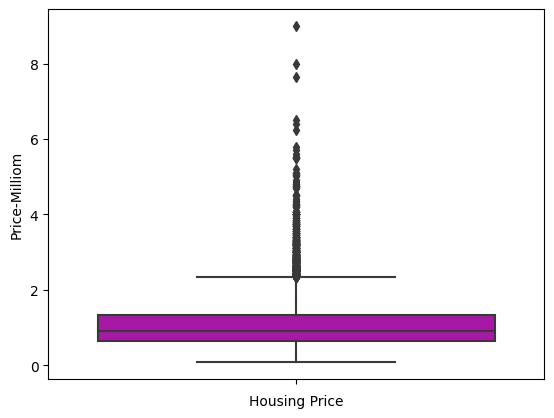

In [61]:
ax= sns.boxplot(palette=["m"],
            data=house['Price(Million)'])
ax.set(xlabel='Housing Price',ylabel='Price-Milliom',xticklabels=[])

In [62]:
def funnel_plot(df,col,top):
    # pick out the top ten features of one column with the biggest amount of real estates, and other features will be integrated into one feature named 'others'
    data =df[col].value_counts().head(top)
    others=df[~df[col].isin(data.index)][col].shape[0]
    data_toframe = data.to_frame(name='Count') #convert picked-out series transferred into dataframe

    # build a new series, convert index into one new column, adding to last dataframe, easy for drawing funnel plotly
    new_row=pd.Series(others,index=['Count'],name='Others') #index is new column name set,name is related index
    new_frame = data_toframe.append(new_row,ignore_index=False).sort_values(by='Count',ascending=False).reset_index()
    new_frame.rename(columns={'index':col},inplace=True)

    # graph_objects trace go.Funnel
    fig = go.Figure(go.Funnel(
             y=new_frame[col].values,
             x=new_frame['Count'].values,
             textposition = "inside",
             textinfo = "value+percent total"
            )
        )
    fig.update_layout(showlegend=False,height=900, width=900)

    fig.show()

In [63]:
funnel_plot(house,'Suburb',10)

<Axes: xlabel='Type', ylabel='count'>

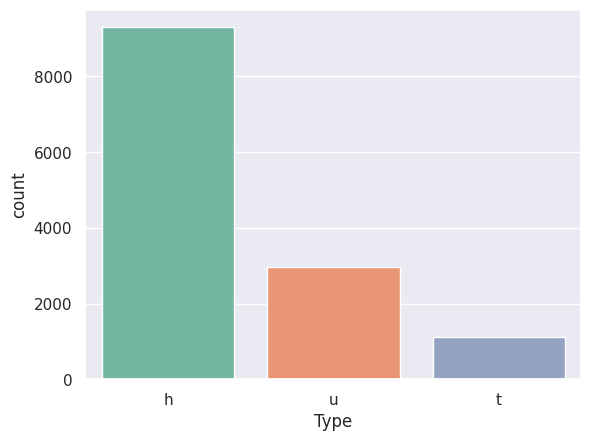

In [64]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.countplot(data=house, x='Type', palette='Set2')


In [65]:
# We firstly use pie chart to show the distribution, mainly focus on top 10
# data_sell=df_house['SellerG'].value_counts().head(10)
# data_sell.to_frame(name='SellerG')
# data_sell.plot.pie(autopct="%.1f%%",figsize=(10, 10))
funnel_plot(house,'SellerG',10)

In [66]:
# To tell the format of date column is consistent
m1 = house['Date'].eq('') | house['Date'].isna()
m2 = pd.to_datetime(house['Date'],format='%d/%m/%Y',errors='coerce').isna()

m1.eq(m2).all()

True

In [67]:
house['Postcode'].dtypes

dtype('float64')

In [68]:
house['Postcode'] = house['Postcode'].astype('int')

% of null: 0.46348209613515734%


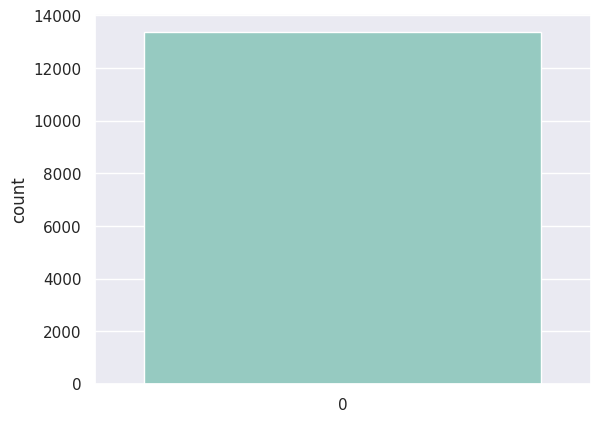

In [69]:
null(house,'Car',True)

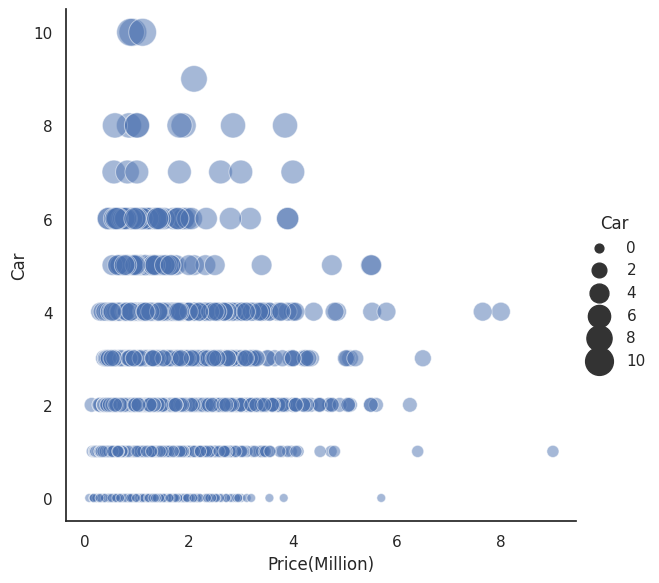

In [70]:
#find car and price relationship to decide how to deal with null value
sns.set_theme(style="white")

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="Price(Million)", y="Car", size="Car",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=house)

In [71]:
house['Car'].fillna(house['Car'].value_counts().index[0], inplace=True)
house['Car'].isnull().sum()

0

In [72]:
null(house,'YearBuilt')

% of null: 39.56043956043956%


In [73]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13377 entries, 0 to 13579
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Suburb          13377 non-null  object 
 1   Address         13377 non-null  object 
 2   Rooms           13377 non-null  int64  
 3   Type            13377 non-null  object 
 4   Price(Million)  13377 non-null  float64
 5   SellerG         13377 non-null  object 
 6   Date            13377 non-null  object 
 7   Postcode        13377 non-null  int64  
 8   Bedroom2        13377 non-null  float64
 9   Bathroom        13377 non-null  float64
 10  Car             13377 non-null  float64
 11  Landsize        13377 non-null  float64
 12  YearBuilt       8085 non-null   float64
 13  Lattitude       13377 non-null  float64
 14  Longtitude      13377 non-null  float64
 15  Regionname      13377 non-null  object 
dtypes: float64(8), int64(2), object(6)
memory usage: 2.2+ MB


In [74]:
process_df= house[['YearBuilt','Price(Million)','Rooms','Bathroom','Car','Suburb','Type']]

In [75]:
#transfer non-numeric data columns into numeric type with labelencoder
process_df[['Suburb','Type']]=process_df[['Suburb','Type']].apply(LabelEncoder().fit_transform)

In [76]:
# KNN used to fill null value
imputer = KNNImputer(n_neighbors=6,weights='uniform', metric='nan_euclidean')

imputer.fit(process_df.values)

# transform the dataset
Xtrans = imputer.transform(process_df.values)

house['YearBuilt'] = Xtrans[:,:1].flatten().round(0).astype(int)

In [77]:
house.shape

(13377, 16)

In [78]:
fig_dis = make_subplots(rows=3, cols=2,subplot_titles=('Rooms','Price(Million)','Bathroom','Car','Landsize'))

fig_dis.add_trace(go.Violin(y=house['Rooms'],
                            box_visible=True,
                            meanline_visible=True,
                            line_color='black',
#                             fillcolor='lightseagreen',
                            opacity=0.5,
                            x0='Rooms number'),
              row=1, col=1
             )
fig_dis.add_trace(go.Violin(y=house['Price(Million)'],
                            box_visible=True,
                            meanline_visible=True,
                            line_color='red',
#                             fillcolor='lightseagreen',
                            opacity=0.5,
                            x0='Price'),
              row=1, col=2
             )
fig_dis.add_trace(go.Violin(y=house['Bathroom'],
                            box_visible=True,
                            meanline_visible=True,
                            line_color='blue',
#                             fillcolor='lightseagreen',
                            opacity=0.5,
                            x0='Bathroom number'),
              row=2, col=1
             )
fig_dis.add_trace(go.Violin(y=house['Car'],
                            box_visible=True,
                            meanline_visible=True,
                            line_color='purple',
#                             fillcolor='lightseagreen',
                            opacity=0.5,
                            x0='Parking spot number'),
              row=2, col=2
             )
fig_dis.add_trace(go.Violin(y=house['Landsize'],
                            box_visible=True,
                            meanline_visible=True,
                            line_color='green',
#                             fillcolor='lightseagreen',
                            opacity=0.5,
                            x0='Land size'),
              row=3, col=1
             )


fig_dis.update_layout(showlegend=False,height=1000, width=1000)
fig_dis.show()

In [79]:
# restore a dataframe including Suburb','Price(Million)','Date','SellerG','Type' so that draw graphs to analyse relationship bewteen time and selling price and selling number
house_rate = house[['Suburb','Price(Million)','Date','SellerG','Type']]
house_rate['Date'] = pd.to_datetime(house_rate['Date'])
house_rate['Num'] = 1

In [80]:
time_price = house_rate[['Date','Price(Million)','Num']].set_index('Date')

In [81]:
# accroding to the same days, calculate everyday's average selling price of real estates and total number of the sold
df_dp = time_price.resample('D').mean().reset_index()
df_numd = time_price.resample('D').sum().reset_index()

In [82]:
fig_area = px.area(df_dp, x='Date', y='Price(Million)', title='Area Visualize - Time Series with Selling House Price - Avg')

fig_area.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
#             dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
    )


fig_scatter = px.scatter(df_dp, x='Date', y='Price(Million)', title='Scatter Visualize - Time Series with Selling House Price - Avg',color_discrete_sequence=['#ca8687'])

fig_scatter.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(bgcolor='#ca8687',bordercolor='#ca8687',
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
#             dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    ),
#      title_font_color='#ca8687',
    color='#ca8687'
    )


fig_area.show()
fig_scatter.show()


#number of houses selling
fig_num = px.line(df_numd, x='Date', y='Num', title='Total Selling House Number- Time Series  ',color_discrete_sequence=['#45b97c'])

fig_num.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(bgcolor='#45b97c',bordercolor='#45b97c',
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
#             dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    ),
#      title_font_color='#ca8687',
    color='#45b97c'
    )


fig_num.show()

In [83]:
# choose the period of time for statistics
period=['10D','3W','m','Q','y']

In [84]:
def draw_avgprice_time(data,period):
    fig, axis = plt.subplots(5, 3, figsize=(30,40))
    color = ['#5c7a29','#5f3c23','#faa755','#bd6758','#d71345']

    for i,p in enumerate (period):
        df = data.resample(p).mean().reset_index()
        df_sum = data.resample(p).sum().reset_index()
        df_num = time_price.resample(p).sum().reset_index()

        fig_new = 'fig'+str(i)
        fig_new_sum = 'fig'+str(i)

#         axis='ax'+str(i)
        fig_new_sum = sns.lineplot(data=df_sum, x='Date', y='Price(Million)',ax=axis[i,0],color=color[i])
        fig_num = sns.lineplot(data=df_num, x='Date', y='Num',ax=axis[i,1],color=color[i])
        fig_new = sns.lineplot(data=df, x='Date', y='Price(Million)',ax=axis[i,2],color=color[i])


        fig_new.set_title('Average Selling Price ('+ p+')',fontsize=15)
        fig_new_sum.set_title('Sum Selling Price ('+ p+')',fontsize=15)
        fig_num.set_title('Total Num of selling ('+ p+')',fontsize=15)

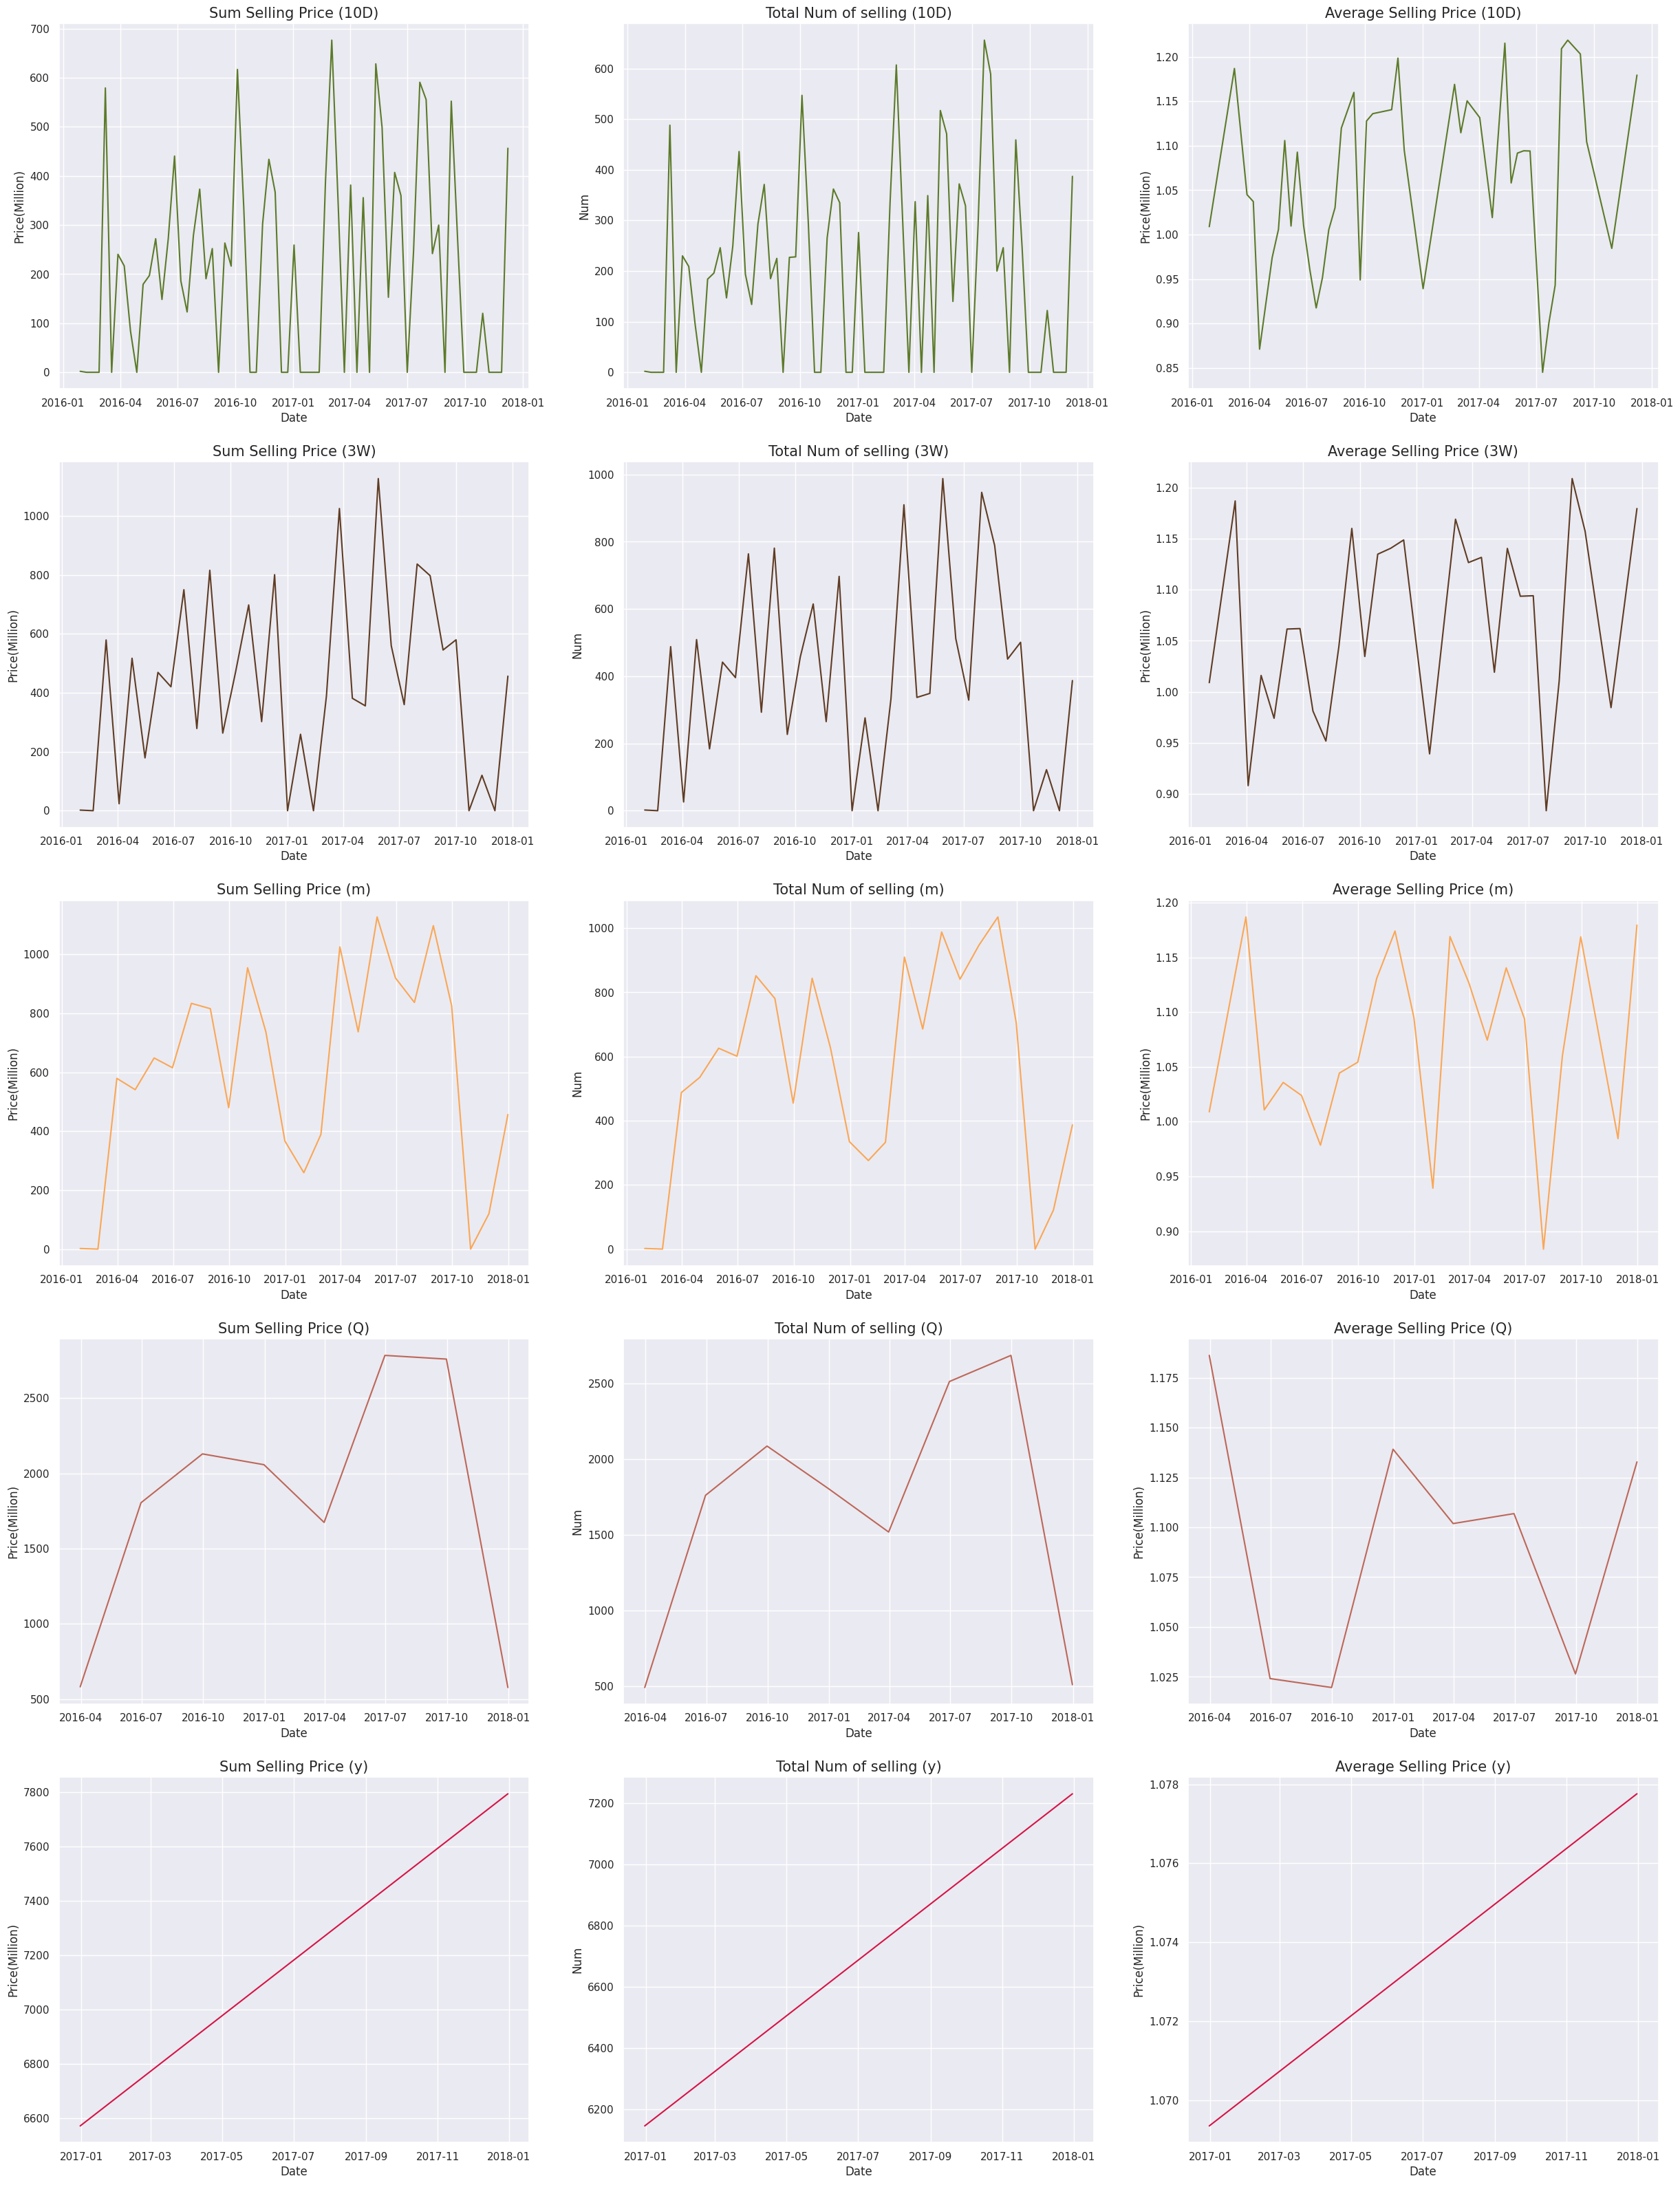

In [85]:
sns.set_theme(style='darkgrid')
draw_avgprice_time(time_price,period)

In [86]:
df_year = time_price.resample('Y').sum().reset_index()

In [87]:
trace_bar=go.Bar(x=df_year['Date'].dt.year.tolist(),y=df_year['Price(Million)'].tolist(),name='Total selling price'
                )

trace_line=go.Line(x=df_year['Date'].dt.year.tolist(),y=df_year['Num'].tolist(),name='Total selling number')

data=[trace_bar,trace_line]

layout= go.Layout(title='Trend of price and selling number in one year',xaxis=dict(title='Year',tickmode='array',tickvals=[2016,2017])
                 )
fig = go.Figure(data,layout)

fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [88]:
trendency_price = ((df_year['Price(Million)'][1]-df_year['Price(Million)'][0])/df_year['Price(Million)'][0]) * 100
trendency_num = ((df_year['Num'][1]-df_year['Num'][0])/df_year['Num'][0])*100

print('From 2016 to 2017, the total sum price of selling real estates increases %d' %trendency_price + '%')
print('From 2016 to 2017, the total number of real estates sold increases %d'%trendency_num +'%')

From 2016 to 2017, the total sum price of selling real estates increases 18%
From 2016 to 2017, the total number of real estates sold increases 17%


In [89]:
# get the maximum of the boxplot
def Upper_Fence(df,col):
    Q1 = df[col].quantile(0.25)
    Q3= df[col].quantile(0.75)

    IQR = Q3 - Q1

    Upper_Fence = Q3 + (1.5 * IQR)
    return Upper_Fence

In [90]:
upper_price = Upper_Fence(time_price,'Price(Million)')

In [91]:
df_Upper_Fence = time_price[time_price['Price(Million)']>=upper_price].reset_index().sort_values(by='Date')

These dates are not holidays which may affect selling prices.


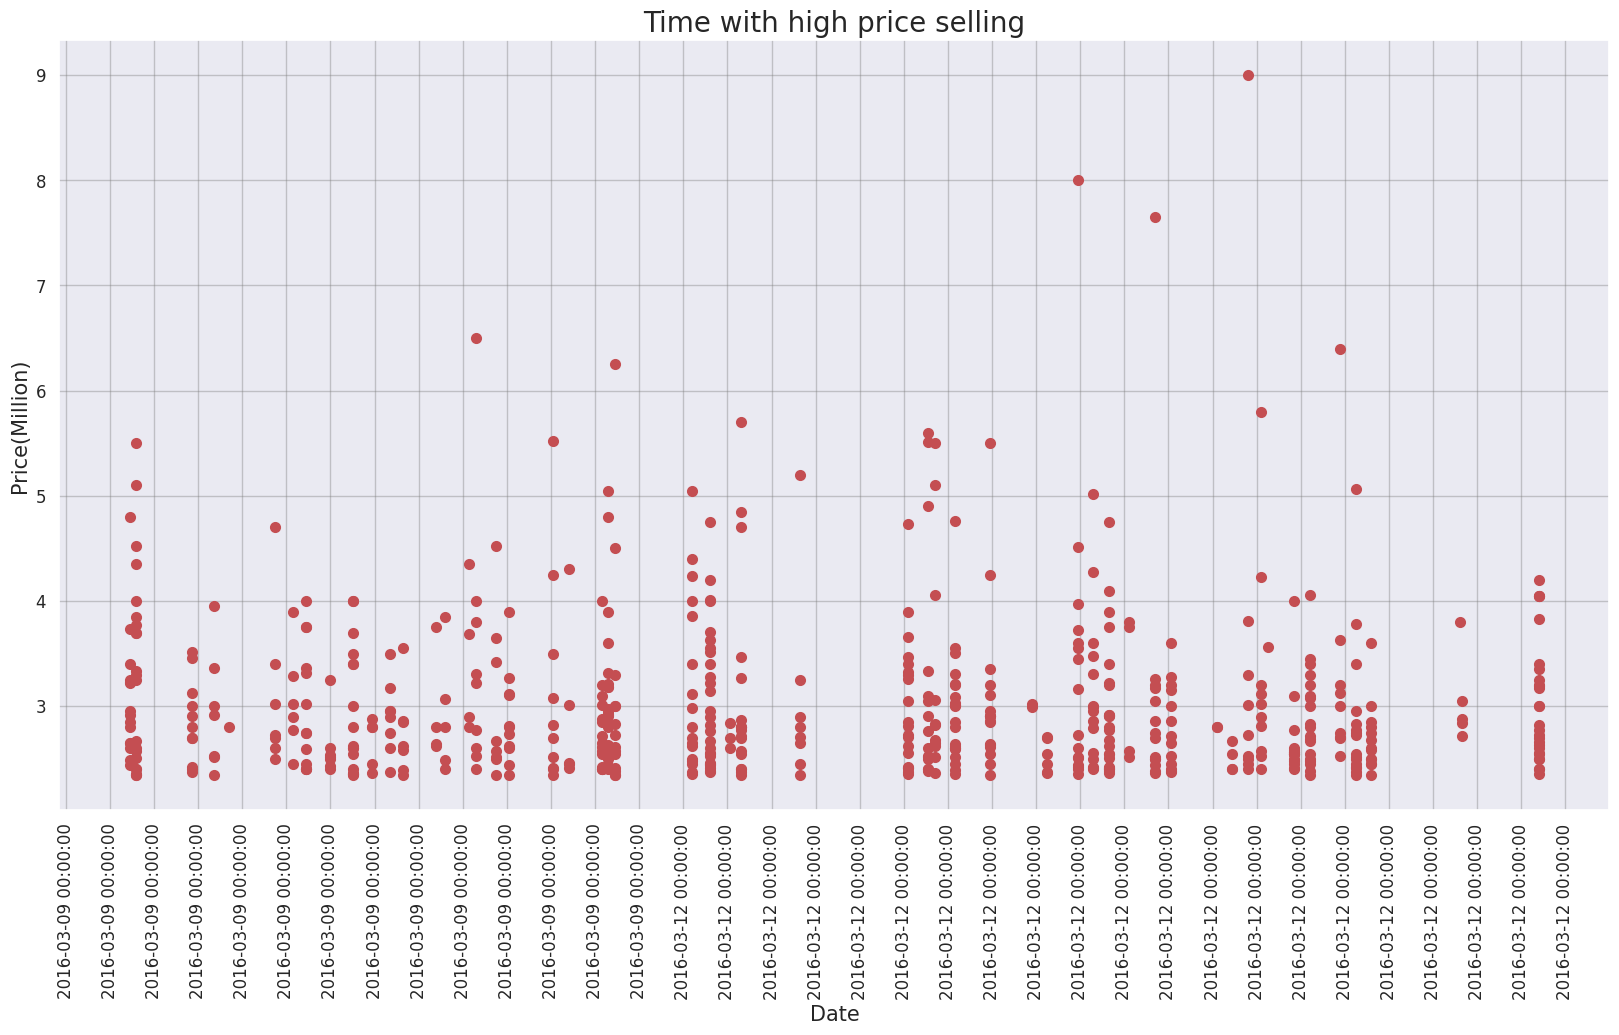

In [92]:
# Select country
AU_holidays = holidays.AU(prov='VIC')


fig,ax=plt.subplots(figsize=(20,10))

x= df_Upper_Fence['Date']
y=df_Upper_Fence['Price(Million)']

ax.scatter(x,y,c='r',lw=2,marker='o')


ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20)) #set aixs intervals,let xticks value not too filled
ax.grid(linestyle = '-',linewidth =1, color= 'gray',alpha = 0.4)
# ax.patch.set_facecolor("")
ax.set_title('Time with high price selling',fontsize=20)
ax.set_ylabel('Price(Million)',fontsize=15)
ax.set_xlabel('Date',fontsize=15)
ax.set_xticklabels(x,rotation=90)
ax.tick_params(labelsize=12)
style = dict(size=15, color='black')

# tell whether there is some day is holiday that cause selling price is high
n=0
for i in x.dt.date:
    if i not in AU_holidays:
        continue
    elif i in AU_holidays:
        ax.annotate(AU_holidays.get(i)+' ('+i+')',xy=(i,list(y)[x.dt.date.index(i)]),xycoords='data',xytext=(50,200),rotation=15,size=13,
                    textcoords='offset points', arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=-0.2",color='black'),
                    bbox=dict(pad=0, facecolor="none", edgecolor="none"))
        n+=1

if n == 0:
    print('These dates are not holidays which may affect selling prices.' )

In [93]:
house_type=house[['Type','Rooms','SellerG','Date','Bedroom2','Bathroom','Car','Landsize','YearBuilt','Price(Million)']]

house_type['Date'] = pd.to_datetime(house_type['Date'])
house_type['Age(Years)']=(house_type['Date'].dt.year)-house_type['YearBuilt']

In [94]:
## relationships between the age of real estates and selling prices
fig_age = px.scatter(house_type, x='Age(Years)', y='Price(Million)', color='Type',
                     size='Price(Million)', hover_data=['Price(Million)','Age(Years)','Rooms','Bedroom2','Bathroom','Car','Landsize','YearBuilt'],
#                      trendline="rolling", trendline_options=dict(function="median", window=5),
                     range_x=[-10,850], range_y=[0,10],
                   )

# fig_age['layout'].pop('updatemenus')
fig_age.update_layout(xaxis=dict(
                        rangeslider=dict(visible=True)
                    ),
                     dragmode="zoom"
                     )
fig_age.show()

In [95]:
house_type[house_type['Age(Years)']<0]


,Type,Rooms,SellerG,Date,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Price(Million),Age(Years)
441,t,3,Nelson,2016-03-12,3.0,3.0,1.0,557.0,2017,0.8510,-1
3489,h,3,Nelson,2016-04-23,3.0,2.0,1.0,630.0,2017,0.8250,-1
5153,h,4,Barry,2016-09-17,3.0,2.0,2.0,834.0,2017,0.7675,-1


In [96]:
house_type['Type'] = house_type['Type'].astype(str)


In [97]:
print(house_type['Type'].unique())


['h' 'u' 't']


In [98]:
print(house_type['Type'].isnull().sum())


0


In [99]:
# Print unique values before and after conversion
print("Unique values before conversion:", house_type['Type'].unique())

# Convert 'Type' column to string type
house_type['Type'] = house_type['Type'].astype(str)

# Print unique values after conversion
print("Unique values after conversion:", house_type['Type'].unique())


Unique values before conversion: ['h' 'u' 't']
Unique values after conversion: ['h' 'u' 't']


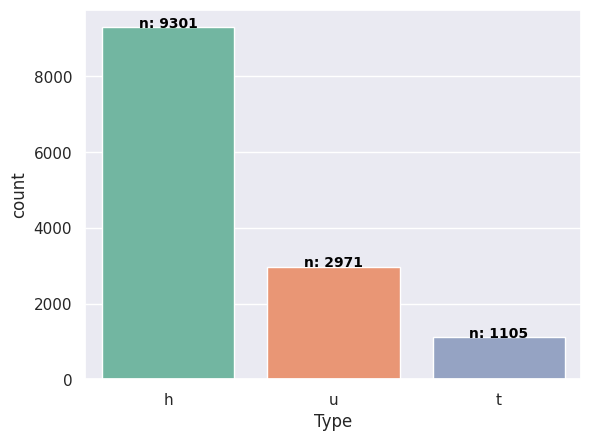

In [100]:
# Convert 'Type' column to string type
house_type['Type'] = house_type['Type'].astype(str)

# Plot the count plot
ax = sns.countplot(data=house_type, x='Type', palette='Set2')

# Add counts on top of the bars
nobs = house_type['Type'].value_counts().values
nob_num = [str(x) for x in nobs.tolist()]
nob = ["n: " + i for i in nob_num]

pos = range(len(nob))
for tick, label in zip(pos, ax.patches):
    ax.text(label.get_x() + label.get_width() / 2, label.get_height() + 0.06, nob[tick],
            horizontalalignment='center', size='small', color='black', weight='semibold')

plt.show()


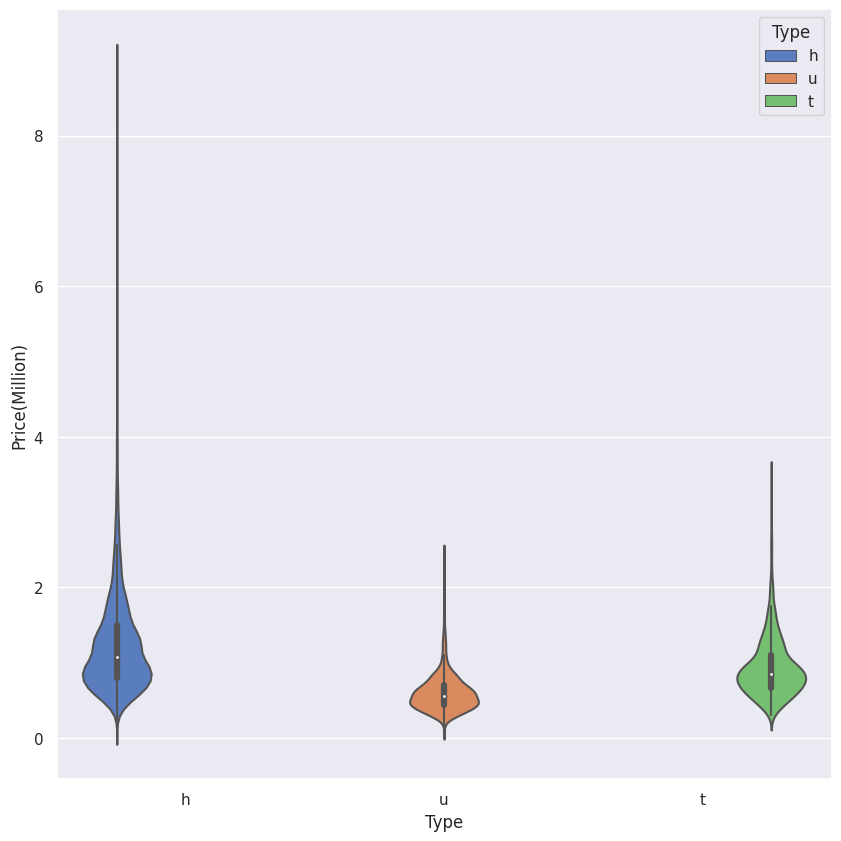

In [101]:
fig_type, ax_type = plt.subplots(figsize=(10,10))
ax_type=sns.violinplot(x=house_type['Type'],y=house_type['Price(Million)'],hue=house_type['Type'],palette="muted")

In [102]:
df_type_price = house_type[['Type','Date','Price(Million)']]

In [103]:
df_type_price['Date']=df_type_price['Date'].dt.year

In [104]:
df_type_sum = df_type_price.groupby(['Type','Date']).agg({'Price(Million)':'sum'})

In [105]:
df_type_sum = df_type_sum.reset_index()

In [106]:
df_type_avg = df_type_price.groupby(['Type','Date']).agg({'Price(Million)':'median'})
df_type_avg = df_type_avg.reset_index()

In [107]:
# trace_sum=go.Bar(x=df_type_sum['Date'],y=df_type_sum['Price(Million)'].tolist(),name='Total selling price of different types', marker=df_type_sum['Type'], barmode="group"
#                 )

# trace_median=go.Line(x=df_type_avg['Date'],y=df_type_avg['Price(Million)'].tolist(),name='Median selling price of different types')


# data=[trace_sum,trace_median]

# layout= go.Layout(title='Trend of price and selling number in one year',xaxis=dict(title='Year',tickmode='array',tickvals=[2016,2017])
#                  )
# fig = go.Figure(data,layout)

# fig.show()

fig_sum = px.area(df_type_sum, x='Date', y='Price(Million)',
             color='Type',range_x=[2016,2017],
             height=400)
fig_sum.show()

In [108]:
fig_median = px.area(df_type_avg, x='Date', y='Price(Million)',
             color='Type',range_x=[2016,2017],
             height=400)
fig_median.show()

In [109]:
fig_hr = px.scatter(house_type[house_type['Type']=='h'], x='Age(Years)', y='Rooms', color='Car',
                     size='Price(Million)', hover_data=['Price(Million)','Age(Years)','Rooms','Bedroom2','Bathroom','Car','Landsize','YearBuilt'],
                     range_x=[-10,250]
                   )

fig_hr.update_layout(xaxis=dict(
                        rangeslider=dict(visible=True)
                    ),
                     dragmode="zoom"
                     )
fig_hr.show()

In [110]:
upper_land = Upper_Fence(house_type,'Landsize')
upper_age = Upper_Fence(house_type,'Age(Years)')

In [111]:
fig_scat_matr = px.scatter_matrix(house_type[(house_type['Landsize']<upper_land) & (house_type['Age(Years)']<upper_age)][['Age(Years)','Rooms','Bathroom','Price(Million)','Landsize','Type','Car']],
                                  dimensions=['Age(Years)','Rooms','Bathroom','Price(Million)','Landsize','Car'],
#                                   symbol='Type',
                                  color="Type",
                                  )

fig_scat_matr.update_layout(
                  width=900,
                  height=900,
                  )
fig_scat_matr.update_traces(diagonal_visible=False)

fig_scat_matr.show()

In [112]:
## SellerG, build top agencies who sell most
top_agency = house_type['SellerG'].value_counts().head(5)
top_agency_df = house_type [house_type['SellerG'].isin(top_agency.index)]

In [113]:
fig_seller = px.violin(top_agency_df, y="Price(Million)", x="SellerG", color="Type", box=False,
                      hover_data=top_agency_df.columns, category_orders={"SellerG": (top_agency_df['SellerG'].value_counts().index)}
                      )
fig_seller.update_traces(meanline_visible=True)
fig_seller.show()

In [114]:
!pip install geopandas


In [115]:
import geopandas as gpd

# Use the absolute path
vic_region = gpd.read_file('/content/melb_data.csv')


In [116]:
import pandas as pd

# Load the 'house' DataFrame from a CSV file
house = pd.read_csv('/content/melb_data.csv')  # Replace 'your_data.csv' with the actual file path

# Now you can use the 'house' DataFrame
house_map = house.drop(['Address', 'SellerG', 'Postcode', 'Regionname'], axis=1)
house_map['Date'] = pd.to_datetime(house_map['Date'])
house_map['Age(Years)'] = (house_map['Date'].dt.year) - house_map['YearBuilt']


In [117]:
print(house_map.columns)


Index(['Suburb', 'Rooms', 'Type', 'Price', 'Method', 'Date', 'Distance',
       'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt',
       'CouncilArea', 'Lattitude', 'Longtitude', 'Propertycount',
       'Age(Years)'],
      dtype='object')


In [118]:
print(house_map.head())


       Suburb  Rooms Type      Price Method       Date  Distance  Bedroom2  \
0  Abbotsford  2      h    1480000.0  S     2016-03-12  2.5       2.0        
1  Abbotsford  2      h    1035000.0  S     2016-04-02  2.5       2.0        
2  Abbotsford  3      h    1465000.0  SP    2017-04-03  2.5       3.0        
3  Abbotsford  3      h    850000.0   PI    2017-04-03  2.5       3.0        
4  Abbotsford  4      h    1600000.0  VB    2016-04-06  2.5       3.0        

   Bathroom  Car  Landsize  BuildingArea  YearBuilt CouncilArea  Lattitude  \
0  1.0       1.0  202.0    NaN           NaN         Yarra      -37.7996     
1  1.0       0.0  156.0     79.0          1900.0     Yarra      -37.8079     
2  2.0       0.0  134.0     150.0         1900.0     Yarra      -37.8093     
3  2.0       1.0  94.0     NaN           NaN         Yarra      -37.7969     
4  1.0       2.0  120.0     142.0         2014.0     Yarra      -37.8072     

   Longtitude  Propertycount  Age(Years)  
0  144.9984    4019

In [119]:
print(house_map.dtypes)


Suburb           object        
Rooms            int64         
Type             object        
Price            float64       
Method           object        
Date             datetime64[ns]
Distance         float64       
Bedroom2         float64       
Bathroom         float64       
Car              float64       
Landsize         float64       
BuildingArea     float64       
YearBuilt        float64       
CouncilArea      object        
Lattitude        float64       
Longtitude       float64       
Propertycount    float64       
Age(Years)       float64       
dtype: object


In [127]:
# Assuming 'house_map' DataFrame is already defined
house_map_summary = house_map[['Suburb', 'Type', 'Rooms', 'Landsize', 'Age(Years)']].groupby(['Suburb', 'Type']).agg({ 'Rooms': 'mean', 'Landsize': 'mean', 'Age(Years)': 'mean'})

# Drop duplicate index values
house_map_summary = house_map_summary[~house_map_summary.index.duplicated(keep='first')]

# Convert index to uppercase and drop duplicates again
house_map_summary.index = house_map_summary.index.set_levels(house_map_summary.index.levels[0].str.upper(), level=0)
house_map_summary = house_map_summary[~house_map_summary.index.duplicated(keep='first')]


In [128]:
#choose only unit data
u_df = house_map_summary.loc[(slice(None),'u'),:].reset_index()
u_df.drop('Type',axis=1,inplace=True)

In [129]:
#choose only townhouse data
t_df = house_map_summary.loc[(slice(None),'t'),:].reset_index()
t_df.drop('Type',axis=1,inplace=True)

In [130]:
def draw_plotmap_num(df,t):

    map= px.choropleth_mapbox(
                    data_frame=df,
                    geojson=vic_region,
                    color='Price(Million)',
                    locations='Suburb',
                    featureidkey='properties.vic_loca_2',
                    mapbox_style="carto-positron",
                    color_continuous_scale='viridis',
                    center={"lat": -37.81110, "lon": 144.97150},
                    hover_data={'Suburb','Rooms','Landsize','Age(Years)'},
                    opacity=0.7,
                    zoom=8,
                    title=t + ' -Average selling price in Melbourne',#map title
    )

    map.update_layout(margin=dict(
        l=0,
        r=0,
        b=50,
        t=30,
    ),height=500,width=600)

    map.show()

In [131]:
def draw_plotmap_num(vic_region, t):
    # Placeholder statement, replace this with your actual function code
    pass

# Assuming vic_region is defined somewhere in your code
vic_region = '/content/suburb-10-vic.geojson'

draw_plotmap_num(vic_region, 'House')
draw_plotmap_num(vic_region, 'Townhouse')
draw_plotmap_num(vic_region, 'Unit')


In [132]:
df_house_sub = house_map.copy()

In [133]:
df_house_sub[(df_house_sub['Type']=='h')& (df_house_sub['Suburb']=='Bentleigh East')].shape

(168, 18)

In [134]:
df_house_sub[df_house_sub['Type']=='h']['Suburb'].value_counts().head(10)

Reservoir         253
Preston           208
Bentleigh East    168
Brunswick         159
Richmond          152
Northcote         151
Coburg            147
Balwyn North      146
Yarraville        141
Glen Iris         137
Name: Suburb, dtype: int64

In [135]:
df_house_sub[df_house_sub['Type']=='t']['Suburb'].value_counts().head(10)

Bentleigh East    47
Pascoe Vale       27
Reservoir         27
Coburg            26
Brighton          26
Maribyrnong       24
Maidstone         24
Bentleigh         23
Brunswick         21
Glenroy           20
Name: Suburb, dtype: int64

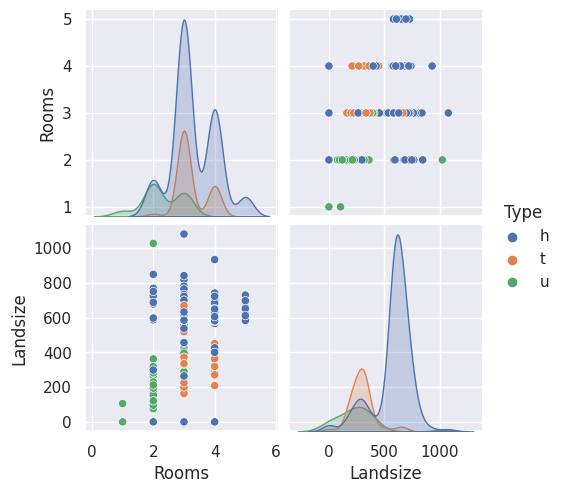

In [141]:
sns.pairplot(df_house_sub[df_house_sub['Suburb']=='Bentleigh East'][['Rooms','Landsize','Type']],hue='Type')

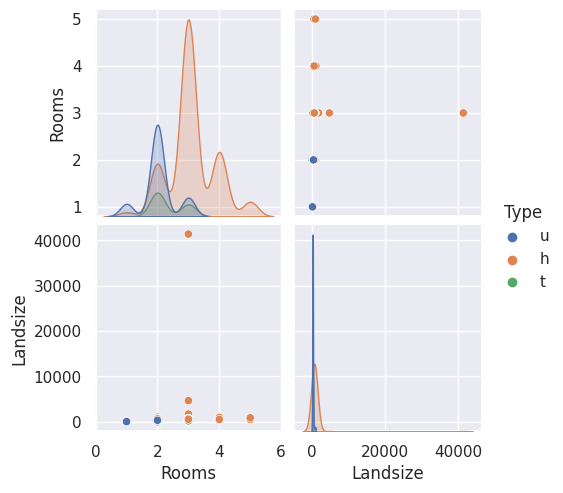

In [139]:
sns.pairplot(df_house_sub[df_house_sub['Suburb']=='Reservoir'][['Rooms','Landsize','Type']],hue='Type')